In [0]:
# Open this notebook in Colab (if you want to train)
# at https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb

In [14]:
# Mount Google Drive at data_dir
#  (for data)
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
DATA = 'My Drive/phutball'
drive.mount(ROOT)
data_dir = join(ROOT, PROJ)
!mkdir "{data_dir}"     # in case we haven't created it already   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/My Drive/phutball’: File exists


In [15]:
# Pull in code from github
github_repo = 'https://github.com/rcharan/phutball'
!git clone {github_repo}
%cd phutball
!git checkout rl

Cloning into 'phutball'...
remote: Enumerating objects: 1361, done.
remote: Counting objects: 100% (1361/1361), done.
remote: Compressing objects: 100% (744/744), done.
remote: Total 1361 (delta 801), reused 1131 (delta 578), pack-reused 0
Receiving objects: 100% (1361/1361), 6.29 MiB | 17.78 MiB/s, done.
Resolving deltas: 100% (801/801), done.


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from lib.model_v1 import TDConway
from lib.moves import create_placement_getter, get_jumps
from lib.utilities import config

from lib.testing_utilities import create_state, visualize_state, boards
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()

import torch

In [0]:
import os
import psutil


import gc

In [0]:
device = torch.device('cpu')
get_placements = create_placement_getter(device)

In [0]:
model = TDConway(config)

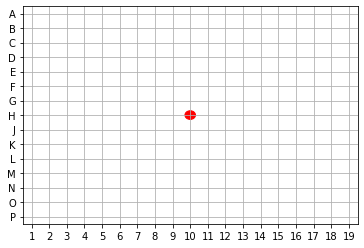

In [0]:
initial_state = create_state('H10')
visualize_state(initial_state)

In [0]:
curr_state = initial_state

In [0]:
BATCH_SIZE = 128
MAX_JUMPS = 300
from lib.moves import END_LOC, COL, CHAIN

In [0]:
from torch.optim import Optimizer

In [0]:
class AlternatingTDLambda(Optimizer):
  '''Implements tracing and updates for the TD(λ) algorithm.
  
  For details see Sutton and Barto, Reinforcement Learning 2ed,
  Chaper 12 Section 2.
  
  Modifications:
    (1) the algorithm is modified to compute traces
        one step early (when the graph is available). Hence, trace must be
        initialized with update_trace before calling step.
        
    (2) Because the board switches sides each turn, eligibility trace updates
        must be of the form z_t+1 <-  -λz_t + 𝝯v
  
  You may find the following greeks a helpful reference:
  alpha : Learning Rate
  lambda: Exponential Decay parameter for the eligibility trace
          (which is essentially momentum but with different
           interpertation and is occasionally zeroed out).
  delta : Temporal difference (TD) i.e. the difference between the estimated
          value of a step and the realized value upon the best move (based
          on further estimation of course).
  '''
  def __init__(self, parameters, alpha, lamda):
    self.alpha = alpha
    self.lamda = lamda # Note alternate spelling (I didn't make it up!)
    defaults   = dict(alpha = alpha, lamda = lamda)

    super(TDLambda, self).__init__(parameters, defaults)
    
  @torch.no_grad()
  def step(self, delta, update_trace = True):
    '''Performs a single optimization step updating the trace *afterwards*
    
    update_trace must be called before first step to initialize the trace.
    
    Arguments
    ---------
    
    delta: Difference between estimated value of move at time t and realized
           value after moving and going to time t+1
    '''
    
    for group in self.param_groups:
      alpha = group['alpha']
      
      for p in group['params']:
        if p.grad is None:
          continue
        
        state = self.state[p]
        
        if len(state) == 0 or 'trace' not in state:
          raise RuntimeError('Traces must be initialized before calling step')
          
        trace = state['trace']
        
        p.add_(alpha * delta * trace) # Note gradient *ascent* in reinforcement learning
    
    if update_trace:
      self.update_trace()

  @torch.no_grad()
  def update_trace(self):
    '''Updates the trace based on the gradients.
    
    This also is the only way to initialize the traces.
    It must be called after evaluating the starting position
    and backprop at the beginning of the game.
    '''
    for group in self.param_groups:
      lamda = group['lamda']
      
      for p in group['params']:
        if p.grad is None:
          continue
        
        state = self.state[p]
        
        # Initialize to zero if necessary
        if len(state) == 0 or 'trace' not in state:
          state['trace'] = torch.zeros_like(p)
          
        trace = state['trace']
        trace.mul_(-lamda).add_(p.grad)
      
  @torch.no_grad()
  def zero_trace(self):
    for group in self.param_groups:
      for p in group['params']:
        state = self.state['p']
        if 'trace' not in state:
          continue
          
        trace = state['trace']
        trace.zero_()
      

In [0]:
from tensorflow.keras.utils import Progbar as ProgressBar

In [0]:
def training_loop(optimizer, num_games, off_policy = lambda _ : None):
  
  initial_state = create_state('H10')
  for i in range(num_games):
    print(f'\nPlaying game {i+1} of {num_games}:')
    game_loop(initial_state, model, optimizer, off_policy)

In [0]:
def restart(optimizer, score):
  optimizer.zero_trace()
  score.backwards()
  optimizer.update_trace()
  optimizer.zero_grad()
  return score.item()

In [0]:
def game_loop(initial_state, model, optimizer, off_policy):
  '''Training loop that plays one game'''
  # Just in case
  optimizer.zero_grad()
  
  # Initialization
  state    = initial_state
  score, _ = model(state.unsqueeze(0))
  v_t      = restart(optimizer, score)
  
  # Progress Bar
  bar      = ProgressBar(284)
  move_num = 1
  
  while True:
    # Determine the next move
    game_over, moved_off_policy, new_state, score = \
      get_next_move_training(curr_state, off_policy = off_policy)
    
    if game_over:      
      delta = 1 - v_t
      optimizer.step(delta, update_trace = False)
      
      # Terminate the progress bar
      bar.target = move_num
      bar.update(move_num)

      break
    
    elif moved_off_policy:
      # Equivalent to starting a new game
      v_t = restart(optimizer, score)
      
    else:
      score.backwards()
      delta = (1 - score) - v_t
      optimizer.step(delta)
      optimizer.zero_grad()
      
      v_t   = score.item()
      state = new_state
      
    # Progress bar
    move_num += 1
    if move_num >= bar.target * 0.9:
      bar.target += bar.target // 10 + 1
    
    bar.update(move_num)
    


In [0]:
def get_next_move_training(curr_state, off_policy = lambda _ : None):
  '''Get the next move for the bot
  
  Gets the next move for the bot with computations and
  return value suitable for training only
  (i.e. gradients are taken)
  
  If off_policy is not None, the off_policy move is
  selected instead.
  
  Gradients with respect to the value-function applied
  at the best move are accumlated and availabe to the caller
  
  Inputs
  ------
  
  curr_state: binary tensor of shape (channels, rows, cols)
              reprenting the game state
              
  off_policy: callable with signature
              off_policy(num_available_moves: int) returning
              either None or the index of the move desired.
              If the return value is not None AND the bot 
              cannot otherwise win on that move, then that
              move is made.
              
  Outputs
  -------
  game_over  : boolean. Whether the bot can (and does) win
             on this move. The bot *always* plays a
             win-in-one move when it is available, regardless
             of the off-policy argument.
             
  off_policy : boolean. Whether an off-policy move was made.
             OR: value is None if game is over
  
  new_state  : a binary tensor of same shape as curr_input
             representing the new state of the game after
             the bot moves AND the board is flipped around
             to present it from opponents view. OR: value
             is None if game is over.
               
  value      : value of the value-function applied to new_state.
             OR: value is None if the game is over.
  '''
  # Compute the placements
  placements = get_placements(curr_state)

  # Compute the jumps
  jumps = get_jumps(curr_state, MAX_JUMPS)

  # Deal with special cases/win condition for the jump
  
  # No jumps to worry about
  if len(jumps) == 0:
    moves = placements
  
  # Win condition
  elif (
    len(jumps) == 1 and
    jumps[0][CHAIN][END_LOC][COL] in [config.cols, config.cols-1]):
    return True, None, None, None # The game is over!
  
  # Regular jump evaluation
  else:
    # Retain only the final state
    jumps = [jump_data[0] for jump_data in jumps]
    jumps = torch.tensor(jumps, dtype = torch.bool)
    moves = torch.cat([placements, jumps])
    
  # Turn the board around to represent the opponent's view
  moves = torch.flip(moves, [-1])
  
  # Either make an off policy move, or evaluate the value-function
  #  to determine the policy
  if off_policy(moves.shape[0]) is not None:
    move     = moves[move].unsqueeze()
    score, _ = model(move)
    return False, True, move, score
  
  # Batch the moves
  batches = torch.split(moves, BATCH_SIZE)
  
  # We only need to differentiate the best score
  #  track which one that is.
  best_score = None
  best_index = None
  curr_index = 0

  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss:,d}')
  
  for batch in batches:

    
    # Run the model
    score, index = model(batch)

    # Update running tally of best score
    #  Old best scores should have their graphs
    #  destroyed

    if best_score is None or score > best_score:
      best_score = score
      best_index = curr_index + index

    # Keep track of how many indices we've traversed to 
    #  get best_index correct
    curr_index += batch.shape[0]
    
    gc.collect()
    
    print(f'{process.memory_info().rss:,d}')
    
  # Return
  return False, False, moves[best_index], best_score

In [0]:
%%time
get_next_move_training(curr_state)